In [ ]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
from google.colab import drive
import numpy as np
import seaborn as sns

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Proyecto colaborativo/3 - ISPC /Procesamiento del Habla/tweet_emotions.csv')


In [ ]:
data.head()



,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...


In [ ]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   40000 non-null  int64 
 1   sentiment  40000 non-null  object
 2   content    40000 non-null  object
dtypes: int64(1), object(2)
memory usage: 937.6+ KB


In [ ]:
data['sentiment'].value_counts()

sentiment
neutral       8638
worry         8459
happiness     5209
sadness       5165
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
empty          827
enthusiasm     759
boredom        179
anger          110
Name: count, dtype: int64

In [ ]:
data[data['sentiment'] == 'sadness']

,tweet_id,sentiment,content
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
6,1956968487,sadness,"I should be sleep, but im not! thinking about ..."
8,1956969035,sadness,@charviray Charlene my love. I miss you
9,1956969172,sadness,@kelcouch I'm sorry at least it's Friday?
...,...,...,...
39882,1753887579,sadness,Heaps keen for next weekend. Mummy. &lt;3
39894,1753902385,sadness,@renagades Have a great day..... if the rain k...
39909,1753902771,sadness,@Ssisch Hmmm... Sisch &amp; sound design. So w...
39939,1753903509,sadness,@watermelon39 haha! And Twitter! Hard though i...


In [ ]:
sentimientos_agrupados = data['sentiment'].value_counts().count()
print("Total de sentimientos:", sentimientos_agrupados)


Total de sentimientos: 13


In [ ]:
sentimientos_esp = {
    'anger': 'enojo',
    'boredom': 'aburrimiento',
    'empty': 'vacío',
    'enthusiasm': 'entusiasmo',
    'fun': 'diversión',
    'happiness': 'felicidad',
    'hate': 'odio',
    'love': 'amor',
    'neutral': 'neutral',
    'relief': 'alivio',
    'sadness': 'tristeza',
    'surprise': 'sorpresa',
    'worry': 'preocupación'
}

In [ ]:
data['sentiment'] = data['sentiment'].map(sentimientos_esp)

##Gráfico


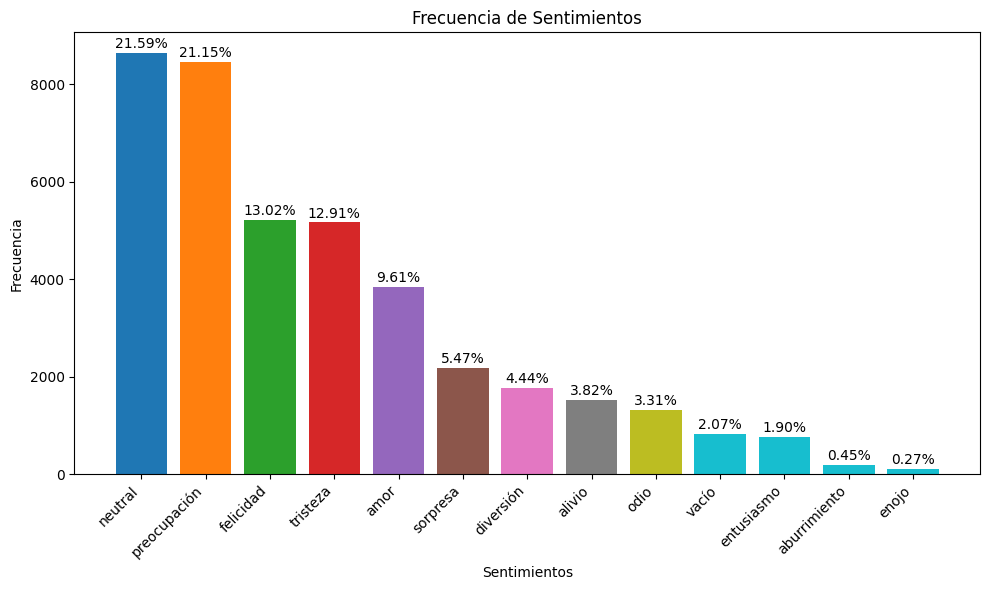

In [ ]:
sentimientos = data['sentiment'].value_counts()
total = sentimientos.sum()

plt.figure(figsize=(10, 6))
plt.bar(sentimientos.index, sentimientos, color=plt.cm.tab10(range(len(sentimientos))))


for i, valor in enumerate(sentimientos):
    porcentaje = (valor / total) * 100
    plt.text(i, valor + 100, f'{porcentaje:.2f}%', ha='center')

plt.title('Frecuencia de Sentimientos')
plt.xlabel('Sentimientos')
plt.ylabel('Frecuencia')

plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()



###ML

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
lemmatizer = WordNetLemmatizer()
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\@[\w_]+', '', text)  # Eliminar menciones de usuarios
    text = re.sub(r'\#', '', text)  # Eliminar hashtags
    text = re.sub(r'[^A-Za-z\s]', '', text)
    tokens = nltk.word_tokenize(text)
    stop_words = set(stopwords.words('spanish'))  # Cambiar a 'english' si tu dataset está en inglés
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

In [ ]:
data['processed_content'] = data['content'].apply(preprocess_text)


In [ ]:
X = data['processed_content']
y = data['sentiment']

In [ ]:
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(X)

In [ ]:
ros = RandomOverSampler(random_state=42)
X_tfidf_resampled, y_resampled = ros.fit_resample(X_tfidf, y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf_resampled, y_resampled, test_size=0.2, random_state=42)


In [ ]:
model = MultinomialNB()
model.fit(X_train, y_train)

MultinomialNB()

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

In [ ]:

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print('Classification Report:')
print(report)

Accuracy: 0.5164522017899283
Precision: 0.4847208370094879
Recall: 0.5164522017899283
F1 Score: 0.49208495303713745
Classification Report:
              precision    recall  f1-score   support

aburrimiento       0.68      0.95      0.79      1753
      alivio       0.47      0.53      0.50      1779
        amor       0.47      0.50      0.48      1696
   diversión       0.50      0.49      0.50      1776
       enojo       0.75      0.97      0.85      1677
  entusiasmo       0.53      0.70      0.60      1753
   felicidad       0.39      0.30      0.34      1786
     neutral       0.27      0.11      0.16      1699
        odio       0.55      0.66      0.60      1670
preocupación       0.30      0.18      0.23      1739
    sorpresa       0.44      0.41      0.42      1741
    tristeza       0.39      0.35      0.37      1687
       vacío       0.56      0.58      0.57      1703

    accuracy                           0.52     22459
   macro avg       0.49      0.52      0.49     2

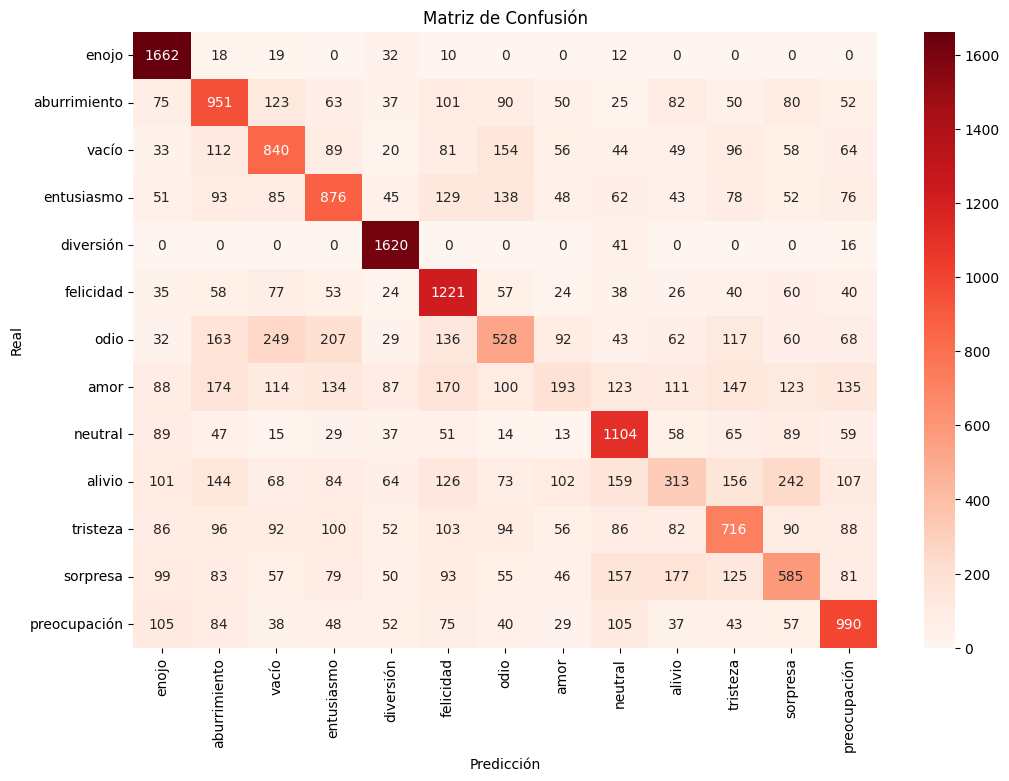

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', xticklabels=sentimientos_esp.values(), yticklabels=sentimientos_esp.values())
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()